In [1]:
import json
from pathlib import Path
import time
from typing import Any, Dict, List, Optional

import jsonlines
import pandas as pd
from tqdm import tqdm

from config import settings

In [2]:
import sys
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
core_src_dir = os.path.join(parent_dir, "src/psiking")
sys.path.append(core_src_dir)

In [3]:
## Import Core Schemas
from core.base.schema import Document, TextNode, ImageNode, TableNode

# 1. Prepare Docling reader
* test image description option
    * https://github.com/DS4SD/docling/blob/main/docs/examples/pictures_description_api.py


## annotations
example:
```
item.annotations
>>
[
    PictureDescriptionData(
        kind='description',
        text='This line graph is called 2021年并更旧的年讀昆一 (2021年攀發明星).',
        provenance='not-implemented'
    )
]
```

In [4]:
from core.reader.pdf.docling_reader import DoclingPDFReader

from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions,
    PictureDescriptionApiOptions
)
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.backend.docling_parse_v2_backend import DoclingParseV2DocumentBackend

In [5]:
format_options = PdfPipelineOptions()
format_options.images_scale = 1.5
format_options.generate_page_images = True
format_options.generate_picture_images = True

format_options.do_ocr = False
format_options.do_table_structure = True

# Image description
print("VLM MODEL:", settings.vlm_model)
image_description_options = PictureDescriptionApiOptions(
    url=f"{settings.vlm_base_url}/v1/chat/completions",
    params=dict(
        model=settings.vlm_model,
        seed=42,
        max_completion_tokens=512,
        temperature=0.9
    ),
    prompt="이미지에 대해 3줄 정도로 설명해 주세요",
    timeout=90,
)
format_options.do_picture_description = True
format_options.picture_description_options = image_description_options

VLM MODEL: Qwen2-VL-72B-Instruct-GPTQ-Int4


In [6]:
reader = DoclingPDFReader(format_options=format_options)

In [7]:
# PDF File directory
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

In [8]:
fnames = ['2024년 3월_3. 향후 통화신용정책 방향.pdf']

# Convert pages to image
documents = []
failed_fnames = []
for doc_i, fname in tqdm(enumerate(fnames)):
    file_path = os.path.join(pdf_dir, fname)
    try:
        document = reader.run(
            file_path,
            extra_info = {
                "source_id": f"allganize-RAG-Evaluation-Dataset-KO/finance/{doc_i}", # arbitrary id
                "domain": "finance",
                "source_file": fname
            }
        )
    except Exception as e:
        print("[READER] failed {} - {}".format(fname, str(e)))
        failed_fnames.append(fname)
        continue
    document.nodes = document.nodes
    documents.append(document)
    
for node in document.nodes[:3]:
    print(type(node))

1it [01:46, 106.33s/it]

ANNOTATIONS [PictureDescriptionData(kind='description', text='이 그래프는 2021년부터 2024년까지의 매출 추이를 보여주는 선 그래프입니다. 각 연도별로 다른 색상의 선으로 표시되어 있으며, x축은 계절을 나타내고, y축은 품목 수를 나타냅니다. 2021년은 파란색, 2022년은 주황색, 2023년은 초록색, 2024년은 빨간색의 선으로 표시되어 있습니다. 그래프를 통해 각 연도별 매출의 변동 추이를 파악할 수 있습니다.', provenance='not-implemented')]
CAPTION: 주: 1) 소비자물가지수 세부품목 458개 중 가중치 0.3% 이상인 80개 품목의 전년동월대비 상승률의 분포(각년도 2월 기준) 자료: 통계청, 자체시산
ANNOTATIONS [PictureDescriptionData(kind='description', text='이 그래프는 두 개의 차트로 구성되어 있으며, 각 차트에는 세 가지 데이터 세트가 표시되어 있습니다. 첫 번째 차트는 "기대인플레이션율"과 "물가인상률"을 보여주며, 두 번째 차트는 "인플레이션 기대 5% 이상 응답비중"과 "인플레이션 기대 1-3% 응답비중"을 나타냅니다. 각 그래프는 시간 경과에 따른 변화를 나타내며, y축은 백분율입니다. 그래프는 시간에 따라 인플레이션과 관련된 기대치 및 물가 인상률의 변화를 시각적으로 보여줍니다.', provenance='not-implemented')]
CAPTION: 
ANNOTATIONS [PictureDescriptionData(kind='description', text='이 그래프는 소비자물가와 근원물가의 전년동기대비 증가율을 보여주고 있습니다. 그래프는 2021년 1월부터 2024년 1월까지의 기간을 커버하며, 소비자물가(파란선)과 근원물가(브라운선)의 추이를 나타냅니다. 소비자물가와 근원물가는 동일한 패턴을 보이며, 주요 증가와 감소를 공유합니다.', provenance='not-implemented'

TEXT: 이 그래프는 2021년부터 2024년까지의 매출 추이를 보여주는 선 그래프입니다. 각 연도별로 다른 색상의 선으로 표시되어 있으며, x축은 계절을 나타내고, y축은 품목 수를 나타냅니다. 2021년은 파란색, 2022년은 주황색, 2023년은 초록색, 2024년은 빨간색의 선으로 표시되어 있습니다. 그래프를 통해 각 연도별 매출의 변동 추이를 파악할 수 있습니다.
CAPTION: 주: 1) 소비자물가지수 세부품목 458개 중 가중치 0.3% 이상인 80개 품목의 전년동월대비 상승률의 분포(각년도 2월 기준) 자료: 통계청, 자체시산


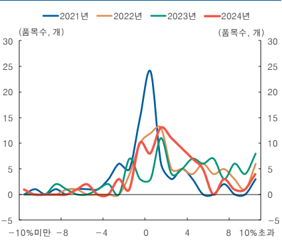

In [10]:
for node in document.nodes:
    if isinstance(node, ImageNode):
        break
print("TEXT:", node.text)
print("CAPTION:", node.caption)
node.image